# 割引クーポンキャンペーンの効果最大化

## 導入

- **目的：割引クーポンを同封したDMを送信し，より多くの会員へ来店してもらう**
     
     
- DMのパターン
    1. セールのチラシのみ
    2. セールのチラシと1000円のクーポン
    3. セールのチラシと2000円のクーポン
    
    
- 制約
    - 予算の制約
        - 100万円
        - 来店しても何も買わない可能性があるので，来店時の消費額の期待値を予算とする
    - 送付率の制約
        - 来店傾向をグループ化したセグメントに属する人数の10％に送付
            - 次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するため

## データ理解

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import pulp

%matplotlib inline

会員データ

In [2]:
df_customer = pd.read_csv('data/4.coupon/customers.csv')
print(df_customer.shape)
df_customer.head()

(5000, 3)


,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [3]:
df_customer.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

|カラム名|名称|データの説明|
|---|---|---|
|customer_id|会員ID|1~5,000の間でユニークな整数値をとる|
|age_cat|年齢区分||
|freq_cat|昨年度来店回数区分||

可視化してみる

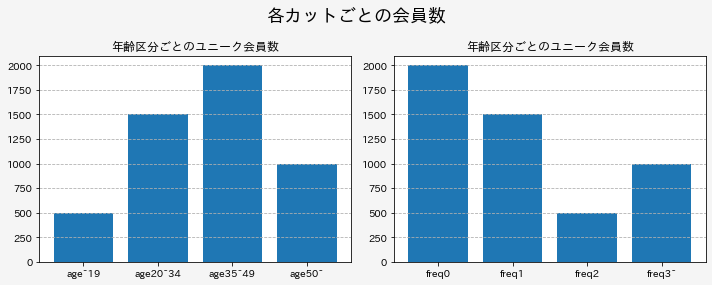

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), facecolor='whitesmoke')
# 年齢区分ごと ... 棒グラフの横軸が勝手にソートされるのでめんどい処理が必要
tmp = df_customer.groupby('age_cat').agg({'customer_id': 'nunique'})
tmp['tmp'] = tmp.index.map({'age~19':0, 'age20~34': 1, 'age35~49': 2, 'age50~': 3})
tmp = tmp.sort_values('tmp')
axes[0].bar(tmp.index, tmp['customer_id'])
axes[0].set_title('年齢区分ごとのユニーク会員数')
axes[0].grid(axis='y', ls='--')
# 来店数区分ごと ... freqはソートされてもOK
tmp = df_customer.groupby('freq_cat').agg({'customer_id': 'nunique'})
axes[1].bar(tmp.index, tmp['customer_id'])
axes[1].set_title('昨年度来店回数区分ごとのユニーク会員数')
axes[1].set_title('年齢区分ごとのユニーク会員数')
axes[1].grid(axis='y', ls='--')

fig.suptitle('各カットごとの会員数', size=18)
fig.show()
plt.tight_layout()

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

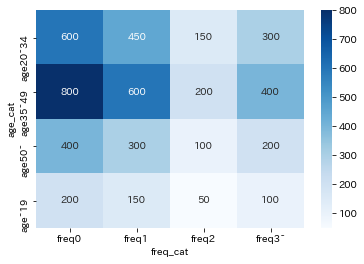

In [29]:
# クロス集計
df_pivot_customer = pd.pivot_table(
    data=df_customer,
    values='customer_id',
    columns='freq_cat',
    index='age_cat',
    aggfunc='count')
display(df_pivot_customer)
# の可視化
sns.heatmap(df_pivot_customer, annot=True, fmt='d', cmap='Blues')

In [32]:
# セグメントごとの来店率データ
# 昨年度の年齢と昨年度来店回数区分でセグメント分け
df_proba = pd.read_csv('data/4.coupon/visit_probability.csv')
print(df_proba.shape)
df_proba

(16, 6)


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [34]:
n_customer_per_seg = df_customer.groupby(['age_cat', 'freq_cat']).agg({'customer_id': 'nunique'}).reset_index()

,age_cat,freq_cat,customer_id
0,age20~34,freq0,600
1,age20~34,freq1,450
2,age20~34,freq2,150
3,age20~34,freq3~,300
4,age35~49,freq0,800
5,age35~49,freq1,600
6,age35~49,freq2,200
7,age35~49,freq3~,400
8,age50~,freq0,400
9,age50~,freq1,300


- `age_cat` : 年齢区分
- `freq_cat` : 昨年度来店回数区分
- `segment_id` : セグメントID．年齢区分と昨年度来店回数区分の組み合わせによる会員のセグメント
- `prob_dm1` : パターン1来店率．当該セグメントにセールのチラシのみのDMを送付したときの来店率
- `prob_dm2` : パターン2来店率．セールチラシと1,000円のクーポンのDMを送付したときの来店率
- `prob_dm3` : パターン3来店率．セールチラシと2,000円のクーポンのDMを送付したときの来店率

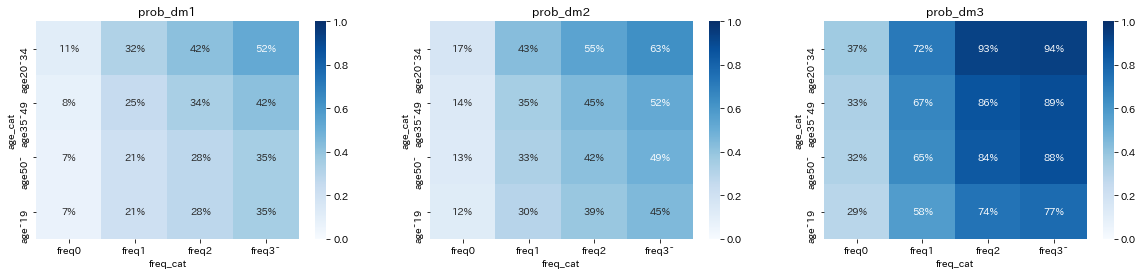

In [46]:
# 各DM送付パターンの来店率をクロス集計
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
for dm_ptn, ax in zip(['prob_dm1','prob_dm2','prob_dm3'], axes):
    df_piv = pd.pivot_table(
        data=df_proba,
        values=dm_ptn,
        columns='freq_cat',
        index='age_cat')
    sns.heatmap(df_piv, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax)
    ax.set_title(dm_ptn)
fig.show()

## モデリング 